In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import torch.nn.functional as F
import matplotlib.pyplot as plt
from copy import deepcopy

In [116]:

class BaseModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BaseModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)



        seed = torch.randint(0, 1000, (1,)).item()
        init_weights(self.fc1, seed)
        init_weights(self.fc2, seed)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)
    
class MetaModel(nn.Module):
    def __init__(self, d):
        super(MetaModel, self).__init__()
        self.d = d
        self.div = d//8
        self.fc1 = nn.Linear(d//self.div, 8)
        self.fc2 = nn.Linear(8, d)
    
    def forward(self, theta_flat):
        outs = []
        if len(theta_flat.shape)==1:
            theta_flat = theta_flat.unsqueeze(0)
        for i in range(0, len(theta_flat), self.d//self.div):
            x = theta_flat[:,i:i+self.d//self.div]
            x = torch.relu(self.fc1(x))
            outs.append(self.fc2(x))
        return torch.cat(outs, dim=0)

    
def init_weights(module, seed=0):
    torch.manual_seed(seed)
    # init weights with xavier 
    if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
        nn.init.xavier_uniform_(module.weight)
        nn.init.zeros_(module.bias)
    #print(f"Init weights with seed {seed}")



In [117]:

input_dim = 1
hidden_dim = 32
output_dim = 1
d = sum(p.numel() for p in BaseModel(input_dim, hidden_dim, output_dim).parameters()) +1

n=1000
X = torch.rand(n, input_dim)*4 -2
Y = torch.tanh(X)
# shuffle
perm = torch.randperm(n)
X = X[perm]
Y = Y[perm]
# random split
X_train, X_test = X[:int(n*0.8)], X[int(n*0.8):]
Y_train, Y_test = Y[:int(n*0.8)], Y[int(n*0.8):]


In [118]:
# 1 model
theta_f = BaseModel(input_dim, hidden_dim, output_dim)
meta_model = MetaModel(d)
optimizer = optim.Adam(meta_model.parameters(), lr=1e-2)
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

for epoch in range(15):
    optimizer.zero_grad()

    # what if we reinit on each iteration? ie can meta model predict final weights from scratch
    # theta_f = BaseModel(input_dim, hidden_dim, output_dim)  
    
    theta_flat = torch.cat([p.flatten() for p in theta_f.parameters()]).requires_grad_(True)
    theta_flat = torch.cat([theta_flat, torch.tensor([epoch], dtype=torch.float32)]).requires_grad_(True)
    
    theta_flat_prime = meta_model(theta_flat).squeeze(0)
    
    theta_f_prime = BaseModel(input_dim, hidden_dim, output_dim)
    
    params_dict = {}
    start_idx = 0
    for name, param in theta_f_prime.named_parameters():
        param_length = param.numel()
        params_dict[name] = theta_flat_prime[start_idx:start_idx + param_length].view_as(param)
        start_idx += param_length
    
    def modified_forward(x):
        # directly pass the weights into the forward pass. keeps the computation graph intact
        x = F.linear(x, 
                    weight=params_dict['fc1.weight'],
                    bias=params_dict['fc1.bias'])
        x = torch.relu(x)
        x = F.linear(x,
                    weight=params_dict['fc2.weight'],
                    bias=params_dict['fc2.bias'])
        return x
    
    outputs = modified_forward(X_train)
    loss = criterion(outputs, Y_train)
    
    loss.backward()
    
    optimizer.step()
    print(f'Epoch {epoch}, Train Loss {loss.item()}\n')
    
    if epoch == 0:
        make_dot(loss, params=dict(list(meta_model.named_parameters()))).render('comp_graph', format='png')
        

Epoch 0, Train Loss 0.5734468102455139

Epoch 1, Train Loss 0.3561665415763855

Epoch 2, Train Loss 0.20541901886463165

Epoch 3, Train Loss 0.10933011770248413

Epoch 4, Train Loss 0.05510542914271355

Epoch 5, Train Loss 0.033849503844976425

Epoch 6, Train Loss 0.03520331531763077

Epoch 7, Train Loss 0.04890383780002594

Epoch 8, Train Loss 0.0646982416510582

Epoch 9, Train Loss 0.07271748781204224

Epoch 10, Train Loss 0.06800239533185959

Epoch 11, Train Loss 0.05400583893060684

Epoch 12, Train Loss 0.037377454340457916

Epoch 13, Train Loss 0.023532535880804062

Epoch 14, Train Loss 0.015263435430824757



In [120]:
# numel
optimizee_params = sum(p.numel() for p in BaseModel(input_dim, hidden_dim, output_dim).parameters())
meta_model_params = sum(p.numel() for p in meta_model.parameters())

print(f"Optimizee params: {optimizee_params}, Meta model params: {meta_model_params}") # currently meta_model >> optimizee.

Optimizee params: 97, Meta model params: 954


In [121]:
#k models
k = 500
batch_size = 8
optimizees = [BaseModel(input_dim, hidden_dim, output_dim) for _ in range(k)]
meta_model = MetaModel(d).to('cuda')
optimizer = optim.Adam(meta_model.parameters(), lr=1e-2)
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
X_train = X_train.to('cuda')
Y_train = Y_train.to('cuda')

for epoch in range(25):
    running_loss = 0.0
    for i in range(0, k, batch_size):
        batch = optimizees[i:i+batch_size]
        batch_flattened = [torch.cat([torch.cat([p.flatten() for p in model.parameters()]), torch.tensor([epoch], dtype=torch.float32)]) for model in batch]
        batch_flattened = torch.stack(batch_flattened).to('cuda')

        optimizer.zero_grad()

        theta_flat_prime = meta_model(batch_flattened)
        
        batch_prime = [BaseModel(input_dim, hidden_dim, output_dim) for _ in range(theta_flat_prime.shape[0])]
        params_dict = {}
        start_idx = 0
        for name, param in batch_prime[0].named_parameters():
            param_length = param.numel() 
            try:
                params_dict[name] = theta_flat_prime[:, start_idx:start_idx + param_length].view(theta_flat_prime.shape[0], *param.shape)
            except:
                print(name, param_length, theta_flat_prime[:, start_idx:start_idx + param_length].shape)
                break
            start_idx += param_length

        def modified_forward(x, idx):
            # directly pass the weights
            x = F.linear(x, 
                        weight=params_dict['fc1.weight'][idx],
                        bias=params_dict['fc1.bias'][idx])
            x = torch.relu(x)
            x = F.linear(x,
                        weight=params_dict['fc2.weight'][idx],
                        bias=params_dict['fc2.bias'][idx])
            return x
        
        
        outputs = [modified_forward(X_train, idx) for idx in range(len(batch_prime))]
        # reassign the outputs to the models
        for i, model in enumerate(optimizees[i:i+batch_size]):
            for name, param in model.named_parameters():
                param.data = params_dict[name][i].cpu()
        loss = torch.stack([criterion(output, Y_train) for output in outputs]).mean()
        loss.backward()
        running_loss += loss.item() * len(batch)
        optimizer.step()
    print(f'Epoch {epoch}, Train Loss {running_loss/len(optimizees)}')
        



Epoch 0, Train Loss 0.05349240155518055
Epoch 1, Train Loss 0.0033467754647135734
Epoch 2, Train Loss 0.000426995464367792
Epoch 3, Train Loss 0.00013714719488052652
Epoch 4, Train Loss 5.154517467599362e-05
Epoch 5, Train Loss 2.351767678919714e-05
Epoch 6, Train Loss 2.5258442969061433e-05
Epoch 7, Train Loss 7.34056506480556e-05
Epoch 8, Train Loss 1.9356284727109595e-05
Epoch 9, Train Loss 1.4436008015763946e-05
Epoch 10, Train Loss 5.8098170542507435e-05
Epoch 11, Train Loss 2.8191078672534787e-05
Epoch 12, Train Loss 4.9805582952103577e-05
Epoch 13, Train Loss 3.6469967511948195e-05
Epoch 14, Train Loss 2.4815549826598725e-05
Epoch 15, Train Loss 6.224983045831322e-05
Epoch 16, Train Loss 2.2746785660274328e-05
Epoch 17, Train Loss 3.850803919340251e-05
Epoch 18, Train Loss 3.5103803005767985e-05
Epoch 19, Train Loss 4.7738420733367094e-05
Epoch 20, Train Loss 4.187559449201217e-05
Epoch 21, Train Loss 5.028922976634931e-05
Epoch 22, Train Loss 3.762023051240248e-05
Epoch 23, Tra

In [122]:
# evaluate overparameterized meta optimizer
k_test = 100
batch_size = 8
optimizees = [BaseModel(input_dim, hidden_dim, output_dim) for _ in range(k_test)]
optimizees_for_adam = [deepcopy(model) for model in optimizees]
meta_model.eval()
X_train = X_train.to('cuda')
Y_train = Y_train.to('cuda')

avg_losses_meta = []
for epoch in range(25):
    running_loss = 0.0
    for i in range(0, k_test, batch_size):
        batch = optimizees[i:i+batch_size]
        batch_flattened = [torch.cat([torch.cat([p.flatten() for p in model.parameters()]), torch.tensor([epoch], dtype=torch.float32)]) for model in batch]
        batch_flattened = torch.stack(batch_flattened).to('cuda')

        theta_flat_prime = meta_model(batch_flattened)
        
        batch_prime = [BaseModel(input_dim, hidden_dim, output_dim) for _ in range(theta_flat_prime.shape[0])]
        params_dict = {}
        start_idx = 0
        for name, param in batch_prime[0].named_parameters():
            param_length = param.numel() 
            params_dict[name] = theta_flat_prime[:, start_idx:start_idx + param_length].view(theta_flat_prime.shape[0], *param.shape)
            
            start_idx += param_length

        def modified_forward(x, idx):
            # directly pass the weights
            x = F.linear(x, 
                        weight=params_dict['fc1.weight'][idx],
                        bias=params_dict['fc1.bias'][idx])
            x = torch.relu(x)
            x = F.linear(x,
                        weight=params_dict['fc2.weight'][idx],
                        bias=params_dict['fc2.bias'][idx])
            return x
        
        
        outputs = [modified_forward(X_train, idx) for idx in range(len(batch_prime))]
        # reassign the weights for the next iteration
        for i, model in enumerate(batch):
            for name, param in model.named_parameters():
                param.data = params_dict[name][i].data.cpu()

        loss = torch.stack([criterion(output, Y_train) for output in outputs]).mean()
        running_loss += loss.item() * len(batch)
    avg_losses_meta.append(running_loss/len(optimizees))
    print(f'Epoch {epoch}, eval Train Loss {running_loss/len(optimizees)}')


avg_losses_adam = [[] for _ in range(25)]
for model in optimizees_for_adam:
    model.to('cuda')
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    for epoch in range(25):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        loss.backward()
        optimizer.step()
        avg_losses_adam[epoch].append(loss.item())
    print(f'Epoch {epoch}, Adam Train Loss {loss.item()}')


Epoch 0, eval Train Loss 0.017968200147151947
Epoch 1, eval Train Loss 0.00040609604911878705
Epoch 2, eval Train Loss 1.856899689300917e-05
Epoch 3, eval Train Loss 7.199543688329868e-06
Epoch 4, eval Train Loss 6.9732332121930085e-06
Epoch 5, eval Train Loss 6.981742444622796e-06
Epoch 6, eval Train Loss 6.981813385209534e-06
Epoch 7, eval Train Loss 6.9812399488000665e-06
Epoch 8, eval Train Loss 6.981141268624924e-06
Epoch 9, eval Train Loss 6.981146725593135e-06
Epoch 10, eval Train Loss 6.981133083172608e-06
Epoch 11, eval Train Loss 6.98111853125738e-06
Epoch 12, eval Train Loss 6.981108072068309e-06
Epoch 13, eval Train Loss 6.981108072068309e-06
Epoch 14, eval Train Loss 6.981108072068309e-06
Epoch 15, eval Train Loss 6.981108072068309e-06
Epoch 16, eval Train Loss 6.981108072068309e-06
Epoch 17, eval Train Loss 6.981108072068309e-06
Epoch 18, eval Train Loss 6.981108072068309e-06
Epoch 19, eval Train Loss 6.981108072068309e-06
Epoch 20, eval Train Loss 6.981108072068309e-06
E

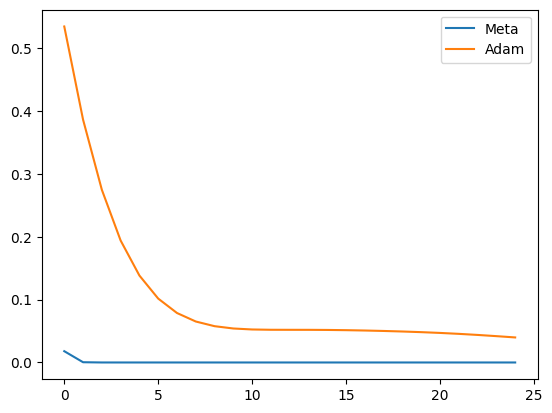

In [123]:
# plto

avg_losses_adam = [sum(losses)/len(losses) for losses in avg_losses_adam]

plt.plot(avg_losses_meta, label='Meta')
plt.plot(avg_losses_adam, label='Adam')
plt.legend()
plt.show()

In [93]:
# baseline
model = BaseModel(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
for epoch in range(15):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, Y)
    
    loss.backward()
    
    optimizer.step()
    print(f'Epoch {epoch}, Loss {loss.item()}\n')
    

Epoch 0, Loss 0.32124263048171997

Epoch 1, Loss 0.30983981490135193

Epoch 2, Loss 0.2987545430660248

Epoch 3, Loss 0.28798747062683105

Epoch 4, Loss 0.2775389850139618

Epoch 5, Loss 0.26740792393684387

Epoch 6, Loss 0.25759318470954895

Epoch 7, Loss 0.24809294939041138

Epoch 8, Loss 0.23890462517738342

Epoch 9, Loss 0.23002487421035767

Epoch 10, Loss 0.22144976258277893

Epoch 11, Loss 0.21317480504512787

Epoch 12, Loss 0.20519483089447021

Epoch 13, Loss 0.19750425219535828

Epoch 14, Loss 0.1900968700647354

